## Fair Generative Adversarial Networks (FairGAN)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the CSV file into a DataFrame
data = pd.read_csv('wholevalue.csv')

In [4]:
# Separate features and target (assuming 'Gender' as the sensitive attribute and 'Course Outcome Level' as the target)
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'
X = data.drop(columns=[sensitive_attr, target])
y = data[target]
gender = data[sensitive_attr]

In [5]:
from scipy.stats import chi2_contingency  # Ensure this import statement is included


# Define the sensitive attribute and target variable
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'

# Check if target outcomes differ significantly by gender using a contingency table and Chi-squared test
contingency_table = pd.crosstab(data[sensitive_attr], data[target])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Contingency Table:\n", contingency_table)
print("\nChi-squared Test Statistic:", chi2)
print("p-value:", p_value)


# Calculate Demographic Parity (average target outcome by gender)
demographic_parity = data.groupby(sensitive_attr)[target].mean()
print("\nDemographic Parity (mean target by gender):\n", demographic_parity)

# Calculate Statistical Parity Difference (absolute difference in mean outcomes between genders)
statistical_parity_difference = abs(demographic_parity.max() - demographic_parity.min())
print("\nStatistical Parity Difference:", statistical_parity_difference)

# Disparate Impact Ratio (ratio of minimum to maximum mean outcomes across genders)
disparate_impact_ratio = demographic_parity.min() / demographic_parity.max()
print("\nDisparate Impact Ratio:", disparate_impact_ratio)

Contingency Table:
 Average Course Outcome Level  0  1   2   3   4   5
Gender                                            
0                             1  4   6  10  59  75
1                             1  0  18   9  39  66

Chi-squared Test Statistic: 13.104645807795107
p-value: 0.022417611636889948

Demographic Parity (mean target by gender):
 Gender
0    4.23871
1    4.12782
Name: Average Course Outcome Level, dtype: float64

Statistical Parity Difference: 0.11089012854717417

Disparate Impact Ratio: 0.9738387063549284


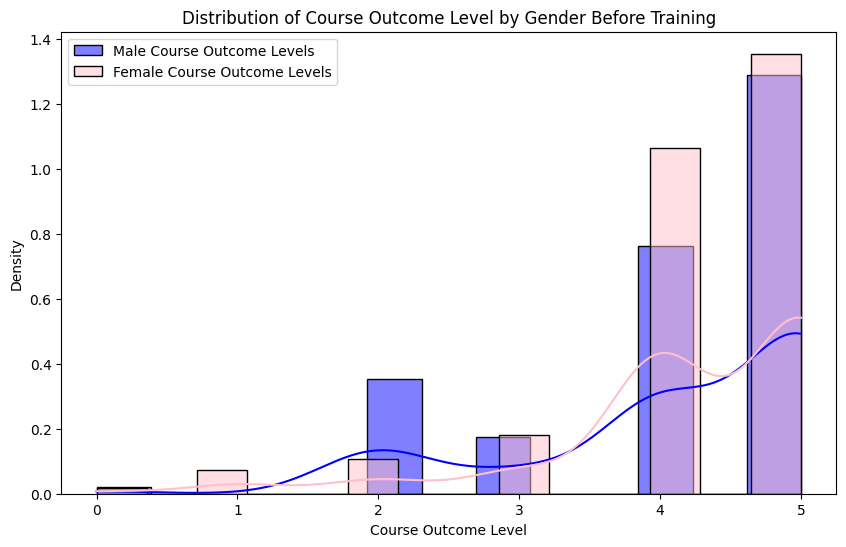

In [6]:
# Plot demographic parity before training
plt.figure(figsize=(10, 6))
sns.histplot(data[target][data[sensitive_attr] == 1], color='blue', label='Male Course Outcome Levels', kde=True, stat="density")
sns.histplot(data[target][data[sensitive_attr] == 0], color='pink', label='Female Course Outcome Levels', kde=True, stat="density")
plt.title("Distribution of Course Outcome Level by Gender Before Training")
plt.xlabel("Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(X, y, gender, test_size=0.2, random_state=42)

In [5]:

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# 2. Model Architecture
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])
    return model


In [7]:

def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
def build_fairness_constraint(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
input_dim = X_train_scaled.shape[1]
output_dim = input_dim  # For generated data with the same dimensions
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(input_dim)
fairness_constraint = build_fairness_constraint(input_dim)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:

# 3. Training Loop for FairGAN
def train_fairgan(generator, discriminator, fairness_constraint, X_train, gender_train, epochs=100, batch_size=64):
    bce_loss = tf.keras.losses.BinaryCrossentropy()
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    fair_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Sample a batch of real data
            real_data = X_train[i:i+batch_size]
            sensitive_labels = gender_train[i:i+batch_size]
            real_labels = np.ones((len(real_data), 1))
            fake_labels = np.zeros((len(real_data), 1))

            # Train Generator
            noise = np.random.normal(0, 1, (len(real_data), input_dim))
            with tf.GradientTape() as tape:
                generated_data = generator(noise, training=True)
                validity_fake = discriminator(generated_data)
                fairness_output = fairness_constraint(generated_data)
                g_loss = bce_loss(real_labels, validity_fake) + bce_loss(sensitive_labels, fairness_output)
            grads = tape.gradient(g_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

            # Train Discriminator
            with tf.GradientTape() as tape:
                validity_real = discriminator(real_data)
                validity_fake = discriminator(generated_data)
                d_loss = bce_loss(real_labels, validity_real) + bce_loss(fake_labels, validity_fake)
            grads = tape.gradient(d_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

            # Train Fairness Constraint Network
            with tf.GradientTape() as tape:
                fairness_output = fairness_constraint(real_data)
                fairness_loss = bce_loss(sensitive_labels, fairness_output)
            grads = tape.gradient(fairness_loss, fairness_constraint.trainable_variables)
            fair_optimizer.apply_gradients(zip(grads, fairness_constraint.trainable_variables))

        # Log Progress
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f} | Fairness Loss: {fairness_loss:.4f}")

In [18]:
# Train the model
train_fairgan(generator, discriminator, fairness_constraint, X_train_scaled, gender_train)

Epoch 1/100 | D Loss: 0.0014 | G Loss: 7.7101 | Fairness Loss: 0.0138
Epoch 2/100 | D Loss: 0.0009 | G Loss: 8.1051 | Fairness Loss: 0.0079
Epoch 3/100 | D Loss: 0.0006 | G Loss: 8.5183 | Fairness Loss: 0.0094
Epoch 4/100 | D Loss: 0.0004 | G Loss: 8.9823 | Fairness Loss: 0.0075
Epoch 5/100 | D Loss: 0.0003 | G Loss: 9.3409 | Fairness Loss: 0.0066
Epoch 6/100 | D Loss: 0.0002 | G Loss: 9.6370 | Fairness Loss: 0.0068
Epoch 7/100 | D Loss: 0.0002 | G Loss: 9.9400 | Fairness Loss: 0.0057
Epoch 8/100 | D Loss: 0.0001 | G Loss: 10.2112 | Fairness Loss: 0.0052
Epoch 9/100 | D Loss: 0.0001 | G Loss: 10.4192 | Fairness Loss: 0.0052
Epoch 10/100 | D Loss: 0.0001 | G Loss: 10.5999 | Fairness Loss: 0.0049
Epoch 11/100 | D Loss: 0.0001 | G Loss: 10.7713 | Fairness Loss: 0.0043
Epoch 12/100 | D Loss: 0.0001 | G Loss: 10.9174 | Fairness Loss: 0.0041
Epoch 13/100 | D Loss: 0.0001 | G Loss: 11.0424 | Fairness Loss: 0.0041
Epoch 14/100 | D Loss: 0.0000 | G Loss: 11.1585 | Fairness Loss: 0.0037
Epoch 15

In [23]:
input_dim = 13  # Original dimension for the noise vector
gender_dim = 1  # Dimension for gender input
input_shape = input_dim + gender_dim  # Total input size (13 + 1 = 14)

# Define the generator model
generator = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),  # Accept input of shape (14,)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Example output layer (binary classification)
])

# Prepare the input for the generator
noise = np.random.normal(0, 1, (len(X_test), input_dim))  # Noise shape (batch_size, 13)
gender_input = np.array(gender_test).reshape(-1, 1)  # Gender input shape (batch_size, 1)

# Concatenate noise with gender input
input_data = np.concatenate([noise, gender_input], axis=1)  # Final shape (batch_size, 14)

# Generate predictions using the updated generator
y_pred = generator(input_data, training=False)  # Use 'training=False' for inference

# Optional: Round predictions for binary classification
y_pred = tf.round(y_pred)

print("Predictions (y_pred):")
print(y_pred)

Predictions (y_pred):
tf.Tensor(
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]], shape=(58, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [26]:
# Step 5: Calculate Demographic Parity
# Separate predictions by gender
male_predictions = y_pred[gender_input.flatten() == 1]  # Male group (gender = 1)
female_predictions = y_pred[gender_input.flatten() == 0]  # Female group (gender = 0)

# Calculate the mean predictions for each gender
male_mean_pred = np.mean(male_predictions)
female_mean_pred = np.mean(female_predictions)

# Calculate the absolute difference to assess demographic parity
demographic_parity_diff = abs(male_mean_pred - female_mean_pred)

# Step 6: Print results
print(f"Demographic Parity - Male Mean Prediction: {male_mean_pred:.3f}")
print(f"Demographic Parity - Female Mean Prediction: {female_mean_pred:.3f}")
print(f"Absolute Difference (Should be close to 0 for parity): {demographic_parity_diff:.3f}")

Demographic Parity - Male Mean Prediction: 0.577
Demographic Parity - Female Mean Prediction: 0.688
Absolute Difference (Should be close to 0 for parity): 0.111


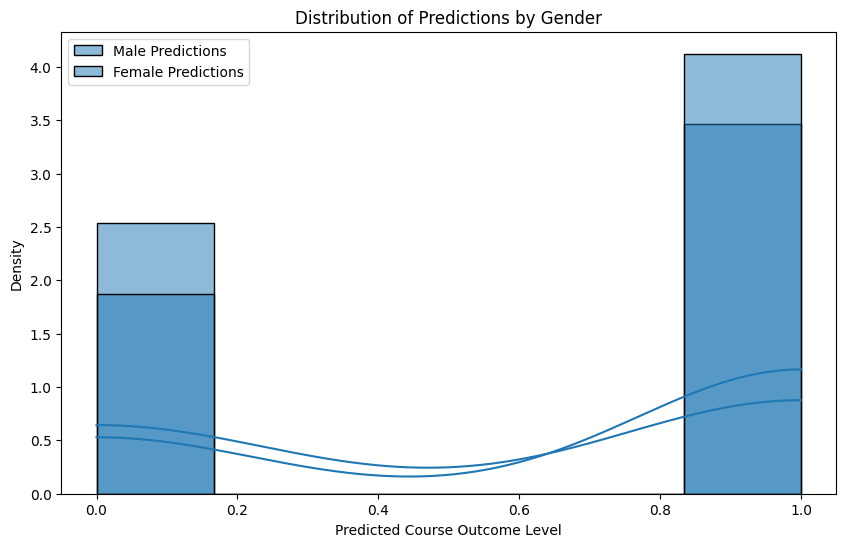

In [27]:
# Plot distributions of predictions for each gender to visualize demographic parity
plt.figure(figsize=(10, 6))
sns.histplot(male_predictions, color='blue', label='Male Predictions', kde=True, stat="density")
sns.histplot(female_predictions, color='pink', label='Female Predictions', kde=True, stat="density")
plt.title("Distribution of Predictions by Gender")
plt.xlabel("Predicted Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

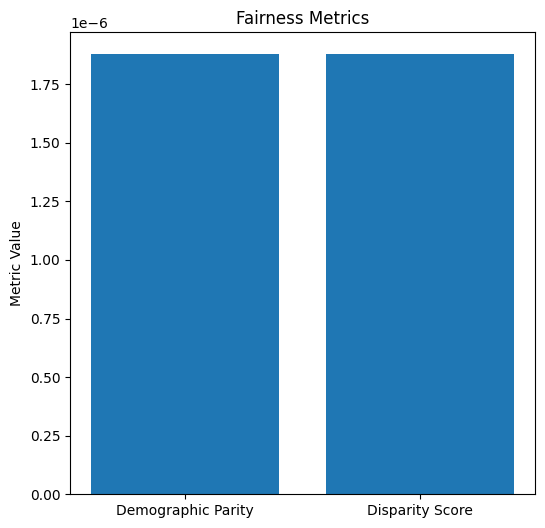

In [28]:
# Plot Fairness Metrics
plt.figure(figsize=(6, 6))
plt.bar(['Demographic Parity', 'Disparity Score'], [demographic_parity_value, disparity_score_value])
plt.ylabel("Metric Value")
plt.title("Fairness Metrics")
plt.show()